In [1]:
import sys
import os

path = os.path.dirname(os.path.abspath('__file__'))
sys.path.insert(0, path + '/../..')
import tensorflow as tf
print(tf.__version__)
import tf_agents.policies
import tf_agents.specs
from tf_agents.environments import suite_gym, parallel_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.policies import policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer, episodic_replay_buffer
from tf_agents.drivers import dynamic_episode_driver, dynamic_step_driver
tf.config.set_visible_devices([], 'GPU')  #  allows testing during training
from tf_agents.trajectories import time_step as ts, policy_step, trajectory
from reinforcement_learning import labeling_functions
labeling_function = labeling_functions.get('Acrobot-v1')
from util.io.dataset_generator import map_rl_trajectory_to_vae_input
from util.io.dataset_generator import ErgodicMDPTransitionGenerator
from tf_agents.environments.wrappers import HistoryWrapper
from policies.saved_policy import SavedTFPolicy
from policies.time_stacked_states import TimeStackedStatesPolicyWrapper
import tf_agents.trajectories.time_step as ts
from tf_agents.specs.array_spec import BoundedArraySpec
from tf_agents import specs
from reinforcement_learning import environments
from reinforcement_learning.environments import acrobot
import importlib

2.4.1


In [16]:
py_env = suite_gym.load('Acrobot-v1')
py_env.reset()
tf_env = tf_py_environment.TFPyEnvironment(py_env)

In [6]:
n = 0
def display_labeling(trajectory):
    global n
    if n % 10 == 0:
        #input(trajectory.observation)
        print(trajectory.observation)
    n += 1

reward_metric = tf_metrics.AverageReturnMetric()
sac_policy_dir = '../saves/Acrobot-v1/dqn_policy'
saved_policy = SavedTFPolicy(sac_policy_dir)
dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env, saved_policy, num_episodes=5,
    observers=[
        # display_labeling,
        lambda _: py_env.render(mode='human'),
        reward_metric
    ]).run()
reward_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=-64.4>

In [3]:
import variational_mdp

vae_mdp = variational_mdp.load(
    "../../saves/Acrobot-v1/models/vae_LS14_MC1_ER10.0-decay=5e-05-min=0_KLA0.0-growth="
    "5e-05_TD0.67-0.50_1e-06-2e-06_seed=20210611_PER-priority_exponent=0.66-WIS_exponent="
    "0.4-WIS_growth_rate=7.5e-05loss_based_priorities_params=full_vae_optimization-relaxed_state_encoding-"
    "latent_policy/base",
    step=450000, discrete_action=True
)
print("VAE MDP loaded")

vae_mdp.eval_policy(eval_env=py_env, labeling_function=labeling_function, num_eval_episodes=20, render=True)

VAE MDP loaded
eval policy -87.2


<tf.Tensor: shape=(), dtype=float32, numpy=-87.2>

In [4]:
history_wrapper_env = HistoryWrapper(env=py_env)
_tf_env = tf_env
tf_env = tf_py_environment.TFPyEnvironment(history_wrapper_env)

In [6]:
reward_metric = tf_metrics.AverageReturnMetric()
sac_policy_dir = '../saves/Acrobot-v1/dqn_policy'
saved_policy = SavedTFPolicy(sac_policy_dir)
policy = TimeStackedStatesPolicyWrapper(saved_policy, history_length=3)
dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env, policy, num_episodes=5,
    observers=[
        lambda _: py_env.render(mode='human'),
        reward_metric
    ]).run()
reward_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=-64.0>

In [6]:
tf_env.current_time_step()

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 3, 6), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.999524  ,  0.03085134,  0.99521226, -0.09773725,
          0.07216357,  0.02589382]]], dtype=float32)>)

In [6]:
labeling_function(tf_env.current_time_step().observation)

<tf.Tensor: shape=(1, 3, 7), dtype=bool, numpy=
array([[[False,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True, False,  True, False]]])>

In [7]:
labeling_function(tf_env.current_time_step().observation)[:, -1, ...]

<tf.Tensor: shape=(1, 7), dtype=bool, numpy=array([[False,  True,  True,  True, False,  True, False]])>

In [8]:
tf_env.current_time_step().observation[:, -1, ...]

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.99768126,  0.06805926,  0.99792546, -0.06438001,  0.06003963,
        -0.04305384]], dtype=float32)>

In [11]:
labeling_function(tf_env.current_time_step().observation[:, -1, ...])

<tf.Tensor: shape=(1, 7), dtype=bool, numpy=array([[False,  True,  True,  True, False,  True, False]])>

In [12]:
x = tf_env.current_time_step().observation[:, -1, ...]

In [13]:
x

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.99768126,  0.06805926,  0.99792546, -0.06438001,  0.06003963,
        -0.04305384]], dtype=float32)>

In [14]:
x[:, -1, ...]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.04305384], dtype=float32)>

In [9]:
tf_env.current_time_step()

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 3, 6), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.9999234 , -0.01237495,  0.9961764 , -0.08736444,
          0.0706172 , -0.00479944]]], dtype=float32)>)

In [11]:
time_step = tf_env.current_time_step()
ts.TimeStep(
    step_type=time_step.step_type,
    reward=time_step.reward,
    discount=time_step.discount,
    observation=time_step.observation[:, -1, ...])

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.9999234 , -0.01237495,  0.9961764 , -0.08736444,  0.0706172 ,
        -0.00479944]], dtype=float32)>)

In [12]:
tf_env.time_step_spec()

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(3, 6), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32)))

In [20]:
spec = _tf_env.time_step_spec()
observation_spec = specs.BoundedTensorSpec(
    shape=(3, ) + spec.observation.shape,
    dtype=spec.observation.dtype,
    name=spec.observation.name,
    minimum=spec.observation.minimum,
    maximum=spec.observation.maximum)
ts.TimeStep(
    step_type=spec.step_type,
    reward=spec.reward,
    discount=spec.discount,
    observation=observation_spec)

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(3, 6), dtype=tf.float32, name='observation', minimum=array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32), maximum=array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32)))

## Random Init Env

tf.Tensor(-52.0, shape=(), dtype=float32)


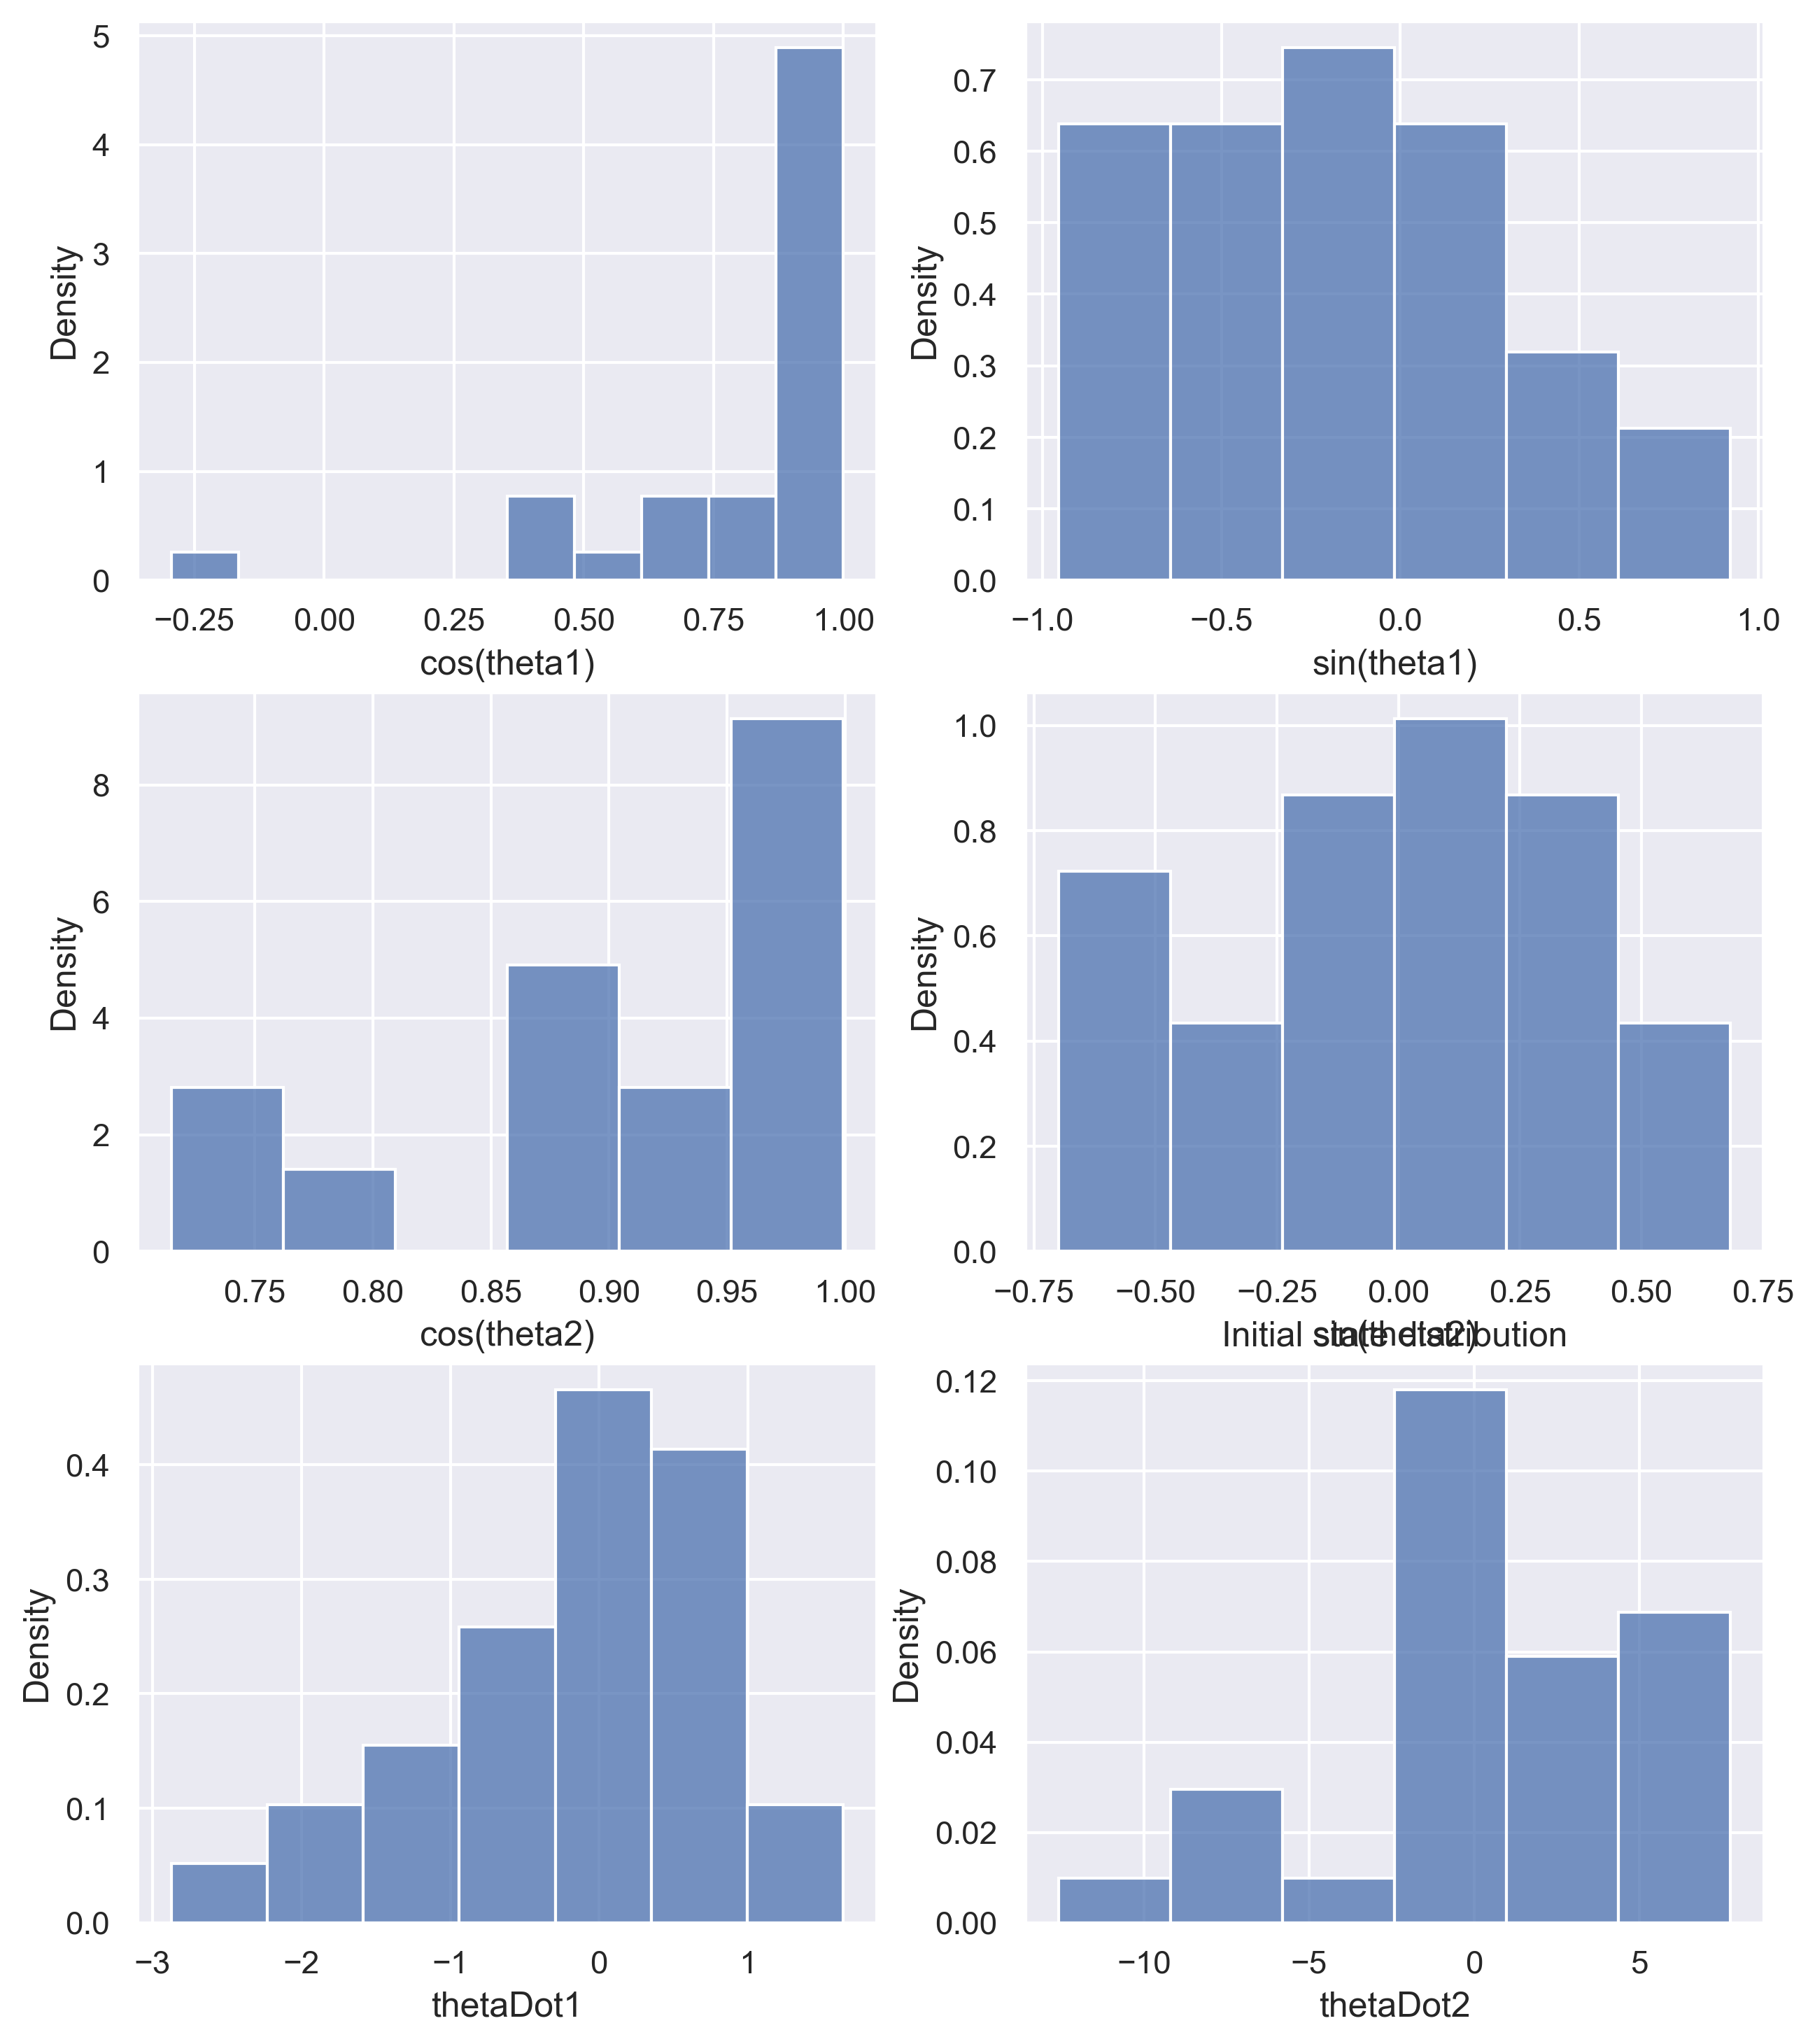

In [15]:
importlib.reload(acrobot)
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_context('notebook')

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


py_env = suite_gym.load('AcrobotRandomInit-v1')
py_env.reset()
tf_env = tf_py_environment.TFPyEnvironment(py_env)

NUM_EPISODES_TEST = 30
RUN_RANDOM_POLICY_DRIVER = False
RENDER = False

initial_states = None

def gather_initial_states(trajectory):
    if trajectory.is_first():
        global initial_states
        if initial_states is None:
            initial_states = trajectory.observation
        else:
            initial_states = np.concatenate([initial_states, trajectory.observation], axis=0)

reward_metric = tf_metrics.AverageReturnMetric()
sac_policy_dir = '../saves/Acrobot-v1/dqn_policy'
saved_policy = SavedTFPolicy(sac_policy_dir)
if RUN_RANDOM_POLICY_DRIVER:
    dynamic_episode_driver.DynamicEpisodeDriver(
        tf_env,
        tf_agents.policies.random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec()),
        # saved_policy,
        num_episodes=NUM_EPISODES_TEST,
        observers=[
            lambda _: py_env.render(mode='human'),
            reward_metric,
        ]).run()

    print(reward_metric.result())

dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env,
    # tf_agents.policies.random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec()),
    saved_policy,
    num_episodes=NUM_EPISODES_TEST,
    observers=[
        lambda _: py_env.render(mode='human') if RENDER else None,
        reward_metric,
        gather_initial_states,
    ]).run()

print(reward_metric.result())

tf_env.close()

columns=['cos(theta1)', 'sin(theta1)', 'cos(theta2)', 'sin(theta2)', 'thetaDot1', 'thetaDot2']
df = pd.DataFrame(
    initial_states,
    columns=columns)
figure, axs = plt.subplots(3, 2, figsize=(10, 12))#, sharey=True)
axs = axs.flatten()
for i, col_name in enumerate(columns):
    _ = sns.histplot(df, x=col_name, stat='density', ax=axs[i])

plt.show()

In [3]:
importlib.reload(acrobot)

py_env = suite_gym.load('AcrobotRandomInit-v1')
py_env.reset()
tf_env = tf_py_environment.TFPyEnvironment(py_env)

NUM_EPISODES_TEST = 10

reward_metric = tf_metrics.AverageReturnMetric()
sac_policy_dir = '../saves/AcrobotRandomInit-v1/dqn_policy'
saved_policy = SavedTFPolicy(sac_policy_dir)
dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env,
    saved_policy,
    num_episodes=NUM_EPISODES_TEST,
    observers=[
        lambda _: py_env.render(mode='human'),
        reward_metric
    ]).run()

print(reward_metric.result())

tf_env.close()

tf.Tensor(-25.7, shape=(), dtype=float32)


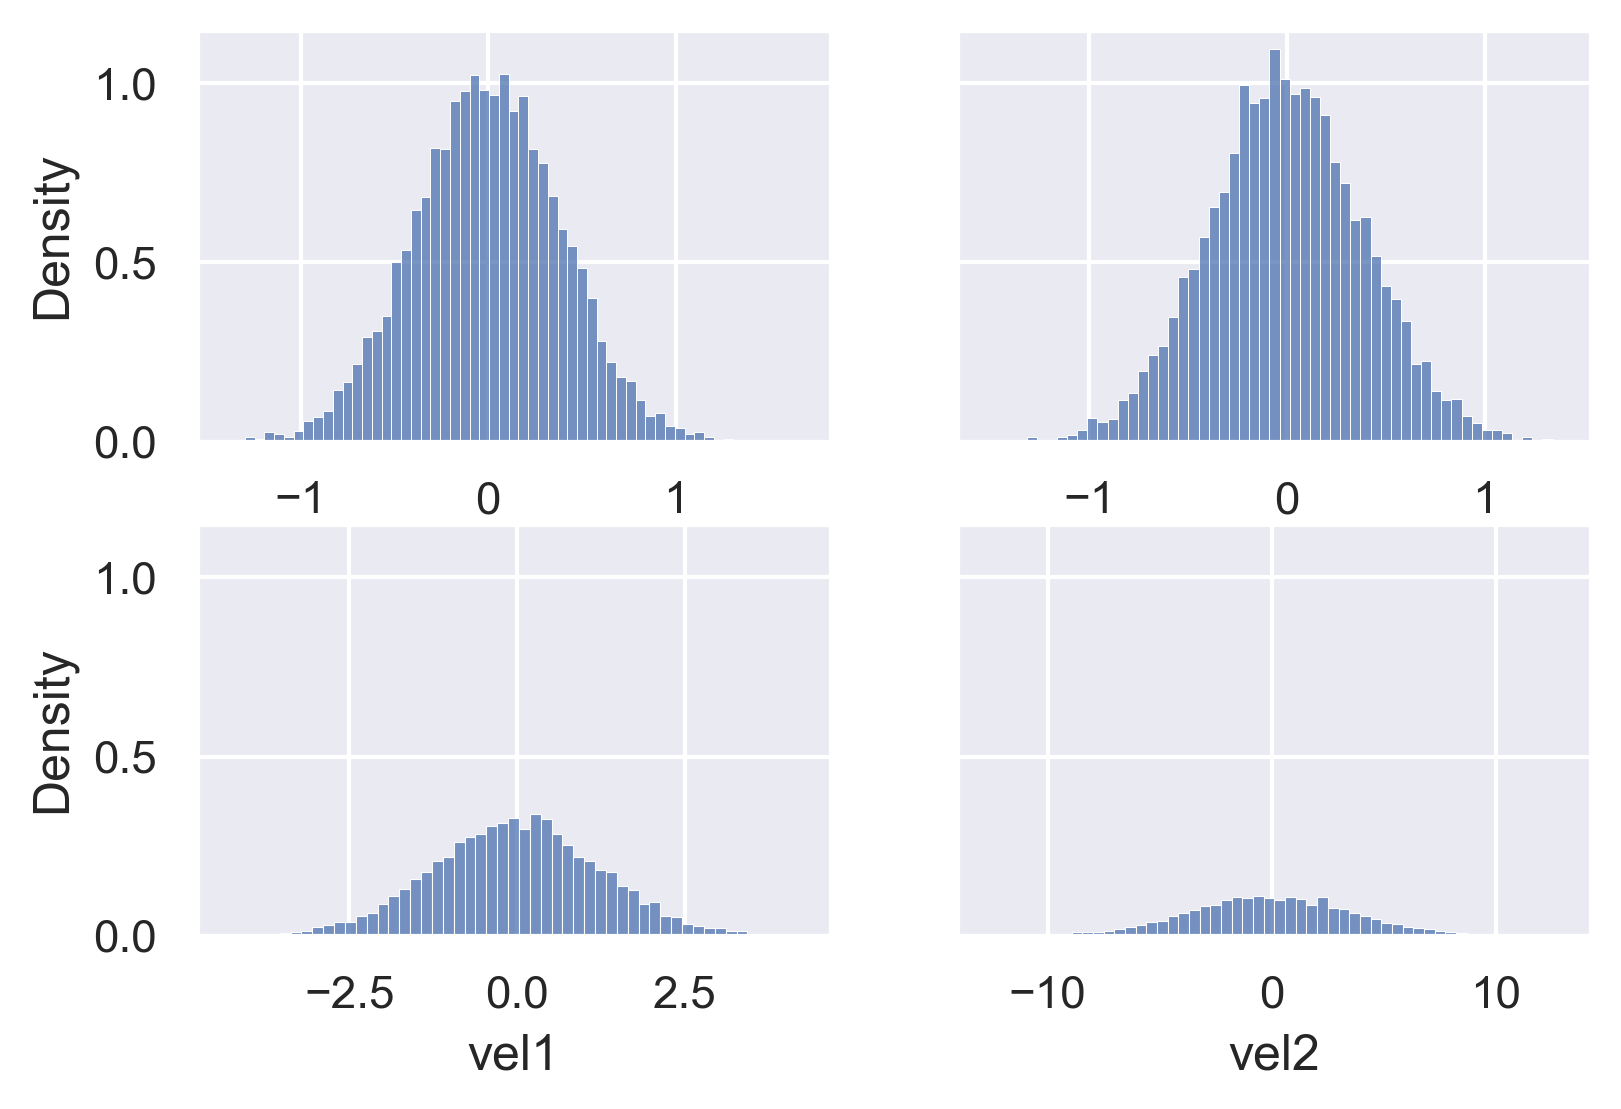

In [3]:
import seaborn as sns
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_context('notebook')

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


MAX_VEL_1 = 4 * np.pi
MAX_VEL_2 = 9 * np.pi
high = np.array([np.pi, np.pi, MAX_VEL_1, MAX_VEL_2])

loc = np.zeros(shape=(4,))
# scale = np.clip(np.array([np.pi / 8, np.pi / 8, MAX_VEL_1 / 24, MAX_VEL_2 / 8]), 0., high)
scale = np.array([np.pi / 6, np.pi / 6, MAX_VEL_1 / 10, MAX_VEL_2 / 8])

state = np.random.normal(loc, scale, size=(2042 * 4, 4))

# df = pd.DataFrame({'value': state.flatten('F'),
#                     'tag': np.repeat(['theta1', 'theta2', 'vel1', 'vel2'], state.shape[0])})
df = pd.DataFrame(state, columns=['theta1', 'theta2', 'vel1', 'vel2'])
figure, axs = plt.subplots(2, 2, sharey=True)
axs = axs.flatten()
_ = sns.histplot(df, x='theta1', stat='density', ax=axs[0])
_ = sns.histplot(df, x='theta2', stat='density', ax=axs[1])
_ = sns.histplot(df, x='vel1', stat='density', ax=axs[2])
_ = sns.histplot(df, x='vel2', stat='density', ax=axs[3])

plt.show()

In [41]:
np.repeat(['chien', 'chat', 'dog'], 5)

array(['chien', 'chien', 'chien', 'chien', 'chien', 'chat', 'chat',
       'chat', 'chat', 'chat', 'dog', 'dog', 'dog', 'dog', 'dog'],
      dtype='<U5')

In [5]:
import numpy as np

x = np.empty(shape=(0, 4))
np.concatenate([x, np.expand_dims(np.array([1, 2, 3, 4]), 0)], axis=0)

array([[1., 2., 3., 4.]])